# Sea Surface Temperature Anomaly Analysis Notebook

This notebook demonstrates an end-to-end pipeline for processing MUR L4 sea surface temperature (SST) anomaly data. It performs the following steps:

1.  **Import libraries** and set up the environment.
2.  **Search for and load** the satellite netCDF files.
3.  **Inspect file structure** to list variables.
4.  **Extract data on a GPU** using CuPy and parallel processing.
5.  **Clip, bin, and plot** the rasterized sea surface temperature anomaly data for the Texas-Louisiana Shelf.
6.  **Apply selective NaN interpolation** to the binned data and plot the result.

Below, the code cells document each step in detail.

### Library Imports

The following cell imports essential libraries required for file handling, numerical operations, data manipulation, and plotting.

In [1]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr # For inspecting netCDF file structure

import sys
sys.dont_write_bytecode = True

# Import custom pipeline components
import importlib
# Assuming l3_pipeline.py is in the same directory or accessible via PYTHONPATH
import l3_pipeline 
importlib.reload(l3_pipeline)

from l3_pipeline import L3DatasetLoader, GPUDataExtractor, SelectiveInterpolator

### Searching for Data Files

This cell specifies the data directory and recursively searches for netCDF files containing satellite SST data.

In [2]:
# Specify the data directory and search recursively for netCDF files
data_dir = r"E:\satdata\MUR-JPL-L4-GLOB-v4.1_Texas Louisiana Shelf_2024-06-01_2024-06-30"
nc_files = glob.glob(os.path.join(data_dir, '**', '*.nc'), recursive=True)
print(f"Found {len(nc_files)} files.")

Found 31 files.


### Inspecting File Structure

This cell opens the first found netCDF file to list its variables, data variables, and coordinates. This helps confirm the names for 'sst_anomaly', 'lat', and 'lon'. MUR L4 files typically store these in the root of the file with 'lat' and 'lon' as 1D coordinates.

In [3]:
# Inspect variables in the first netCDF file
if not nc_files:
    print("No netCDF files found to inspect.")
else:
    file_to_inspect = nc_files[0]
    print(f"Inspecting variables in: {file_to_inspect}\n")
    try:
        with xr.open_dataset(file_to_inspect) as ds:
            print("All Variables (including coordinates):")
            for var_name in ds.variables:
                print(f"  - {var_name}")
                print(f"    Dimensions: {ds[var_name].dims}")
                if hasattr(ds[var_name], 'attrs'):
                    if 'long_name' in ds[var_name].attrs:
                        print(f"    Long name: {ds[var_name].attrs['long_name']}")
                    if 'units' in ds[var_name].attrs:
                        print(f"    Units: {ds[var_name].attrs['units']}")
            
            print("\nData Variables:")
            for var_name in ds.data_vars:
                print(f"  - {var_name}")
                print(f"    Dimensions: {ds[var_name].dims}")
                if hasattr(ds[var_name], 'attrs'):
                    if 'long_name' in ds[var_name].attrs:
                        print(f"    Long name: {ds[var_name].attrs['long_name']}")
                    if 'units' in ds[var_name].attrs:
                        print(f"    Units: {ds[var_name].attrs['units']}")

            print("\nCoordinates:")
            for coord_name in ds.coords:
                print(f"  - {coord_name}")
                print(f"    Dimensions: {ds[coord_name].dims}")
                if hasattr(ds[coord_name], 'attrs'):
                    if 'long_name' in ds[coord_name].attrs:
                        print(f"    Long name: {ds[coord_name].attrs['long_name']}")
                    if 'units' in ds[coord_name].attrs:
                        print(f"    Units: {ds[coord_name].attrs['units']}")
                        
    except Exception as e:
        print(f"Error inspecting file {file_to_inspect}: {e}")

Inspecting variables in: E:\satdata\MUR-JPL-L4-GLOB-v4.1_Texas Louisiana Shelf_2024-06-01_2024-06-30\20240601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc

All Variables (including coordinates):
  - analysed_sst
    Dimensions: ('time', 'lat', 'lon')
    Long name: analysed sea surface temperature
    Units: kelvin
  - analysis_error
    Dimensions: ('time', 'lat', 'lon')
    Long name: estimated error standard deviation of analysed_sst
    Units: kelvin
  - mask
    Dimensions: ('time', 'lat', 'lon')
    Long name: sea/land field composite mask
  - sea_ice_fraction
    Dimensions: ('time', 'lat', 'lon')
    Long name: sea ice area fraction
  - dt_1km_data
    Dimensions: ('time', 'lat', 'lon')
    Long name: time to most recent 1km data
  - sst_anomaly
    Dimensions: ('time', 'lat', 'lon')
    Long name: SST anomaly from a seasonal SST climatology based on the MUR data over 2003-2014 period
    Units: kelvin
  - time
    Dimensions: ('time',)
    Long name: reference time of s

C:\Users\Makai\AppData\Local\Temp\ipykernel_4928\3171820746.py:8: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  with xr.open_dataset(file_to_inspect) as ds:


### Loading Datasets

Using the custom `L3DatasetLoader`, this cell loads multiple datasets from the discovered netCDF files. We specify `sst_anomaly` as the primary variable. The loader will use the bounding box to subset the data on load, which is efficient for L4 gridded data.

In [4]:
# Define the variable to plot
variable_to_plot = 'sst_anomaly'
variables_to_load = [variable_to_plot]

# === Define Bounding Box for the Texas-Louisiana Shelf ===
lon_min, lon_max = -98, -87  # Degrees West
lat_min, lat_max = 25, 30.5   # Degrees North
bbox = (lon_min, lon_max, lat_min, lat_max)

# Load datasets using L3DatasetLoader
loader = L3DatasetLoader(variables=variables_to_load, bbox=bbox) 
datasets = loader.load_multiple(nc_files)
print(f"Loaded {len(datasets)} datasets.")

f:\Programming\GitHub\nasa-murep-local\cdom_sst\l3_pipeline.py:24: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_path)
f:\Programming\GitHub\nasa-murep-local\cdom_sst\l3_pipeline.py:24: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's defaul

Loaded 31 datasets.


f:\Programming\GitHub\nasa-murep-local\cdom_sst\l3_pipeline.py:24: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_path)
f:\Programming\GitHub\nasa-murep-local\cdom_sst\l3_pipeline.py:24: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's defaul

### GPU Data Extraction

This cell leverages the GPU with CuPy and parallel processing to extract and filter the satellite data. The extractor will provide dedicated `all_lon_gpu` and `all_lat_gpu` arrays for geolocation from the dataset coordinates.

In [5]:
# Create an instance of GPUDataExtractor and extract data on GPU
extractor = GPUDataExtractor(variables=variables_to_load)
all_lon_gpu, all_lat_gpu, all_vars_data_gpu = extractor.extract(datasets)

# Get the sea surface temperature anomaly data
all_ssta_gpu = all_vars_data_gpu[variable_to_plot]

print(f"GPU data extraction complete. Extracted {len(all_lon_gpu)} points.")

GPU data extraction complete. Extracted 14646539 points.


### Binning and Plotting Sea Surface Temperature Anomaly

This cell defines a bounding box for the Texas-Louisiana Shelf, clips the extracted SST anomaly data to this box, computes a 2D binned mean statistic, and then plots it on a map.

In [6]:
from scipy.stats import binned_statistic_2d

# Data is already clipped by the loader, but we can re-apply a mask for safety
# This step is fast as data is already on GPU
mask = (
    (all_lon_gpu >= lon_min) & (all_lon_gpu <= lon_max) &
    (all_lat_gpu >= lat_min) & (all_lat_gpu <= lat_max)
)
clipped_lon = all_lon_gpu[mask]
clipped_lat = all_lat_gpu[mask]
clipped_ssta = all_ssta_gpu[mask]

print(f"Clipped data to {len(clipped_lon)} points within the bounding box.")

# === Define a minimum SST anomaly threshold ===
# Values outside a reasonable range will be treated as NaN
min_ssta_threshold = -20.0 
max_ssta_threshold = 20.0
clipped_ssta[(clipped_ssta < min_ssta_threshold) | (clipped_ssta > max_ssta_threshold)] = np.nan
print(f"Applied SSTA threshold: values outside ({min_ssta_threshold}, {max_ssta_threshold})°C are set to NaN.")

# === Define binning parameters ===
# Adjust bin numbers for desired resolution
lat_bins_count, lon_bins_count = 200, 300 

# === Compute 2D binned mean statistic over the clipped data ===
# Check if there's any data to bin
if clipped_lon.size > 0 and clipped_lat.size > 0 and clipped_ssta.size > 0:
    stat_ssta, lat_edges, lon_edges, _ = binned_statistic_2d(
        clipped_lat, clipped_lon, clipped_ssta, statistic='mean', 
        bins=[lat_bins_count, lon_bins_count],
        range=[[lat_min, lat_max], [lon_min, lon_max]]
    )
    # === Generate meshgrid for pcolormesh using bin edges ===
    lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)
    print("Binning complete.")
else:
    print("No data points found within the specified bounding box for binning. Skipping plotting.")
    stat_ssta = None # Ensure stat_ssta exists for later checks

Clipped data to 14646539 points within the bounding box.
Applied SSTA threshold: values outside (-20.0, 20.0)°C are set to NaN.
Binning complete.


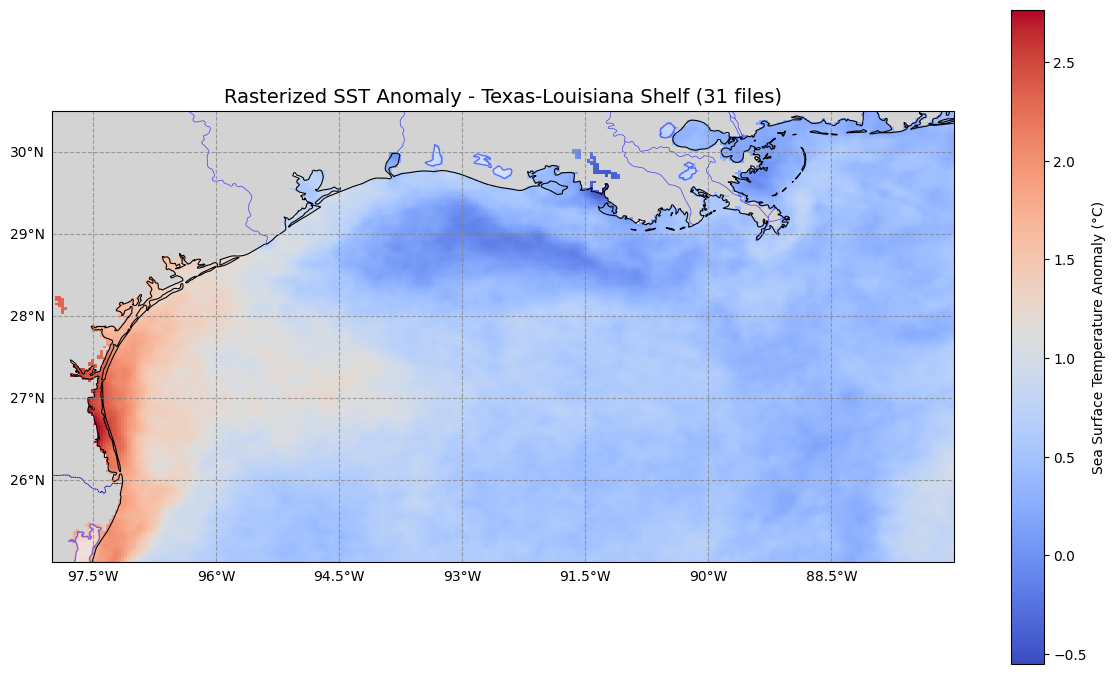

In [7]:
# === Plotting the Rasterized Sea Surface Temperature Anomaly Map ===
if stat_ssta is not None and np.any(~np.isnan(stat_ssta)): # Check if there is data to plot
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set the map extent using the bounding box
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Plot the raster data
    # Using 'coolwarm' colormap which is good for anomalies (blue=cold, red=warm)
    raster = ax.pcolormesh(
        lon_grid, lat_grid, stat_ssta,
        cmap='coolwarm', shading='auto',
        transform=ccrs.PlateCarree()
    )

    # Add coastlines and land features for context
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0) # zorder ensures land is behind coastlines
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.6)
    ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue', alpha=0.7)
    ax.add_feature(cfeature.LAKES, facecolor='aliceblue', edgecolor='blue', alpha=0.5)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.7)
    gl.top_labels = False
    gl.right_labels = False

    # Display a colorbar and map title
    cbar = plt.colorbar(raster, label='Sea Surface Temperature Anomaly (°C)', shrink=0.85, pad=0.05)
    plt.title(f"Rasterized SST Anomaly - Texas-Louisiana Shelf ({len(datasets)} files)", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping plot: No valid binned SSTA data available.")

### Selective NaN Interpolation

This section uses the `SelectiveInterpolator` class from `l3_pipeline` to fill small gaps (NaN regions) in the binned SSTA data while preserving larger NaN regions. This can improve visual continuity without fabricating data over large missing areas.

Selective interpolation complete (threshold: 32 bins).


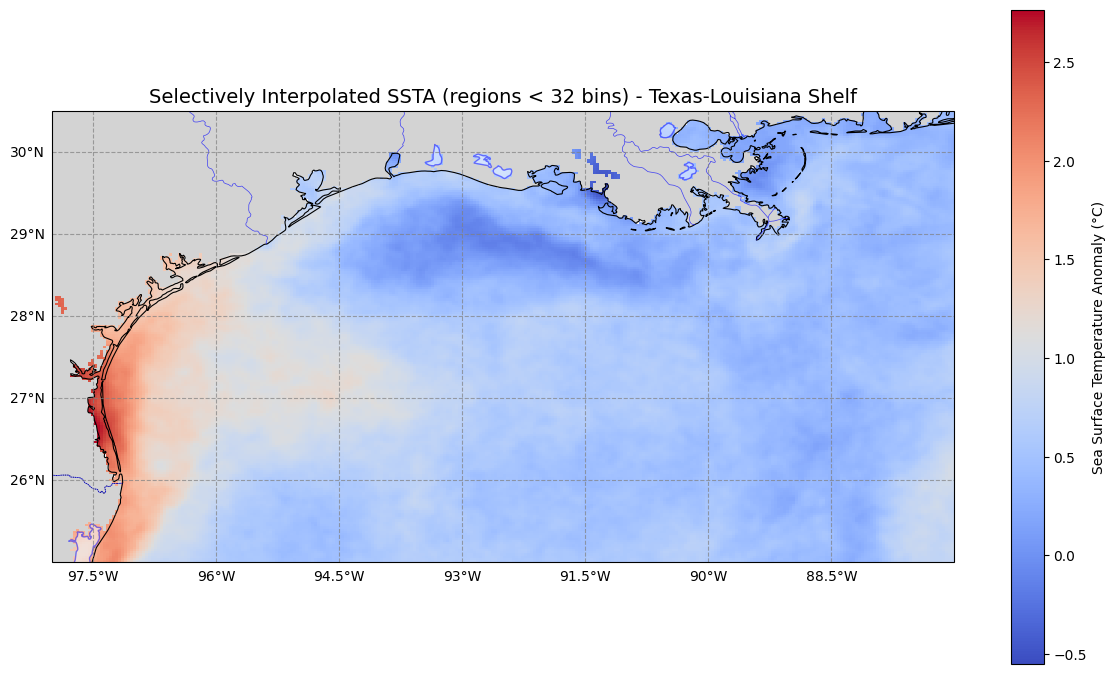

In [8]:
if stat_ssta is not None and np.any(~np.isnan(stat_ssta)): # Proceed only if there's some data
    # Set the threshold for small regions (regions with fewer connected bins than this will be interpolated)
    interpolation_threshold = 32  

    # Use the SelectiveInterpolator class for interpolation
    ssta_selective_interp = SelectiveInterpolator.interpolate(stat_ssta, lat_edges, lon_edges, threshold=interpolation_threshold)
    print(f"Selective interpolation complete (threshold: {interpolation_threshold} bins).")

    # Create a new figure for the selectively interpolated SSTA plot
    fig_interp = plt.figure(figsize=(12, 8))
    ax_interp = plt.axes(projection=ccrs.PlateCarree())

    # Set the map extent
    ax_interp.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Plot the selectively interpolated data
    raster_interp = ax_interp.pcolormesh(
        lon_grid, lat_grid, ssta_selective_interp,
        cmap='coolwarm', shading='auto',
        transform=ccrs.PlateCarree()
    )

    # Add map features
    ax_interp.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
    ax_interp.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax_interp.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.6)
    ax_interp.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue', alpha=0.7)
    ax_interp.add_feature(cfeature.LAKES, facecolor='aliceblue', edgecolor='blue', alpha=0.5)
    
    # Add gridlines
    gl_interp = ax_interp.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.7)
    gl_interp.top_labels = False
    gl_interp.right_labels = False

    # Display colorbar and title
    cbar_interp = plt.colorbar(raster_interp, label='Sea Surface Temperature Anomaly (°C)', shrink=0.85, pad=0.05)
    plt.title(f"Selectively Interpolated SSTA (regions < {interpolation_threshold} bins) - Texas-Louisiana Shelf", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping selective interpolation plot: No valid binned SSTA data available.")